In [1]:
import keras
import tensorflow as tf
import numpy as np
from keras.src.models import Sequential
from keras.src.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Input, LeakyReLU, GlobalAveragePooling2D, BatchNormalization,Rescaling, RandomFlip, RandomRotation,RandomBrightness
from sklearn.utils.class_weight import compute_class_weight
from keras.src.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.src.regularizers import L2

2025-05-01 20:06:21.805894: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746129982.079958      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746129982.156713      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
dir_original_data = "/kaggle/input/brain-tumor-mri-dataset"

train_dataset = keras.utils.image_dataset_from_directory(
    dir_original_data+"/Training",
    labels="inferred",
    label_mode='categorical',
    color_mode='grayscale',
    seed=42
)

test_dataset = keras.utils.image_dataset_from_directory(
    dir_original_data+"/Testing",
    labels="inferred",
    label_mode='categorical',
    color_mode='grayscale',
    seed=42
)

Found 5712 files belonging to 4 classes.


I0000 00:00:1746129999.983477      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746129999.984432      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 1311 files belonging to 4 classes.


In [3]:
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

data_augmentation = Sequential([ RandomFlip("horizontal"), RandomRotation(0.2), ])

def augment(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = data_augmentation(image)
    return image, label

train_dataset = train_dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)


In [4]:



strategy = tf.distribute.MirroredStrategy(["GPU:0", "GPU:1"])
with strategy.scope():

    model = Sequential([ 
    
    Input(shape=(512, 512, 1)),

    Conv2D(32, (7, 7), strides=2, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((3, 3), strides=2),
    
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    
    Conv2D(256, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(256, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dropout(0.5),
    
    Dense(4, activation='softmax')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 32)        │           1,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256, 256, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 127, 127, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 127, 127, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 127, 127, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 127, 127, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 63, 63, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 63, 63, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 63, 63, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 63, 63, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 31, 31, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 31, 31, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 31, 31, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 31, 31, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 31, 31, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,168,452 (4.46 MB)

 Trainable params: 1,166,596 (4.45 MB)

 Non-trainable params: 1,856 (7.25 KB)

data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
])


with strategy.scope():
    model = Sequential([
        Input(shape=(512, 512, 1)),
        Rescaling(1./255),
        data_augmentation,
        
        Conv2D(32, (7, 7), strides=2, padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D((3, 3), strides=2),
        
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        
        Conv2D(256, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(256, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        GlobalAveragePooling2D(),
        Dropout(0.5),
        
        Dense(4, activation='softmax')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )

model.summary()

In [5]:

early_stopping = EarlyStopping(monitor='val_loss', patience=13, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('/kaggle/working/brain_tumor_classifier.keras', save_best_only=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=4, min_lr=1e-12)

history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=test_dataset,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

Epoch 1/100


E0000 00:00:1746130012.347854      31 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1746130014.023327      96 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1746130014.030161      99 cuda_dnn.cc:529] Loaded cuDNN version 90300


179/179 ━━━━━━━━━━━━━━━━━━━━ 35s 112ms/step - accuracy: 0.6290 - auc: 0.8616 - loss: 0.9091 - val_accuracy: 0.2195 - val_auc: 0.5449 - val_loss: 4.3858 - learning_rate: 0.0010
Epoch 2/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 15s 81ms/step - accuracy: 0.7328 - auc: 0.9210 - loss: 0.6755 - val_accuracy: 0.3216 - val_auc: 0.5672 - val_loss: 5.3625 - learning_rate: 0.0010
Epoch 3/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 16s 86ms/step - accuracy: 0.7937 - auc: 0.9478 - loss: 0.5455 - val_accuracy: 0.5625 - val_auc: 0.8183 - val_loss: 1.4398 - learning_rate: 0.0010
Epoch 4/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 15s 84ms/step - accuracy: 0.8150 - auc: 0.9568 - loss: 0.4935 - val_accuracy: 0.6692 - val_auc: 0.8502 - val_loss: 1.2010 - learning_rate: 0.0010
Epoch 5/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 15s 84ms/step - accuracy: 0.8287 - auc: 0.9643 - loss: 0.4469 - val_accuracy: 0.7043 - val_auc: 0.8957 - val_loss: 0.8622 - learning_rate: 0.0010
Epoch 6/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - accuracy: 0.8615 - 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 32)        │           1,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256, 256, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 127, 127, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 127, 127, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 127, 127, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 127, 127, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 63, 63, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 63, 63, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 63, 63, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 63, 63, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 31, 31, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 31, 31, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 31, 31, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 31, 31, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 31, 31, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,501,646 (13.36 MB)

 Trainable params: 1,166,596 (4.45 MB)

 Non-trainable params: 1,856 (7.25 KB)

 Optimizer params: 2,333,194 (8.90 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 833ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━

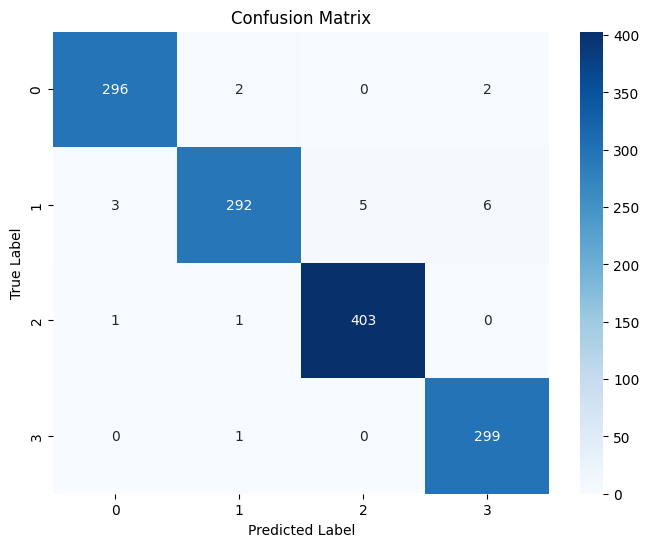

Accuracy: 98.40%


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

model_path = "/kaggle/working/brain_tumor_classifier.keras"

model = keras.models.load_model(model_path)
model.summary()

predictions = []
real_labels = []

for images, labels in test_dataset:
    preds = model.predict(images)
    predictions.extend(np.argmax(preds, axis=1)) 
    real_labels.extend(np.argmax(labels.numpy(), axis=1)) 

cm = confusion_matrix(real_labels, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(4), yticklabels=range(4))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

accuracy = accuracy_score(real_labels, predictions)
print(f"Accuracy: {accuracy:.2%}")